In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
from sklearn.linear_model.coordinate_descent import ConvergenceWarning

from sklearn.model_selection import train_test_split

import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [2]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

##### 1、数据加载

In [28]:
path = "datas/iris.data"
names = ['sepal length', 'sepal width', 'petal length', 'petal width', 'cla']
df = pd.read_csv(path, header=None, names=names)

df.head()

,sepal length,sepal width,petal length,petal width,cla
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


—— Series.value_counts 查看Series的数据类型及数量 ★

In [22]:
df['cla'].value_counts()   # 查看 cla 数据类型及数量

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: cla, dtype: int64

##### 2、数据处理 + 数据分割

In [86]:
datas = df.dropna(how='any')
X = datas[names[0:-1]]
Y = datas[names[-1]]
Y = pd.Categorical(Y).codes   # 1-of-k哑编码化

X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
print ("原始数据条数:%d；训练数据条数:%d；特征个数:%d；测试样本条数:%d" % (len(X), len(X_train), X_train.shape[1], X_test.shape[0]))
print(Y_test)

原始数据条数:150；训练数据条数:90；特征个数:4；测试样本条数:60
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 1 1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2]


##### 3、模型构建 + 训练 + 预测
—— KNeighborsClassifier

    -》n_neighbors 近邻数

In [87]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)

y_predict = knn.predict(X_test)

### 4 绘制ROC曲线 ★

##### 4.1、预测标签概率
—— model.predict_proba() 预测所属不同分类的概率 ★

In [88]:
y_predict_class = knn.predict_proba(X_test)   # 预测为1，2，3值的概率
y_predict_class[0:5]

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

##### 4.2、训练集标签
—— label_binarize(Y,classes) 对标签进行1-of-k编码化，与classes匹配的X[i]值为1，否则为0

    -》classes 匹配标签。对于 N*1 的Y
    ①、如果classes只有两个数，如(0,1)，Y在标签化后仍是 N*1 ；
    ②、当超过两个数字时，如(0,1,2)，会呈现 N*3 矩阵
    
    Z = np.array([1,0,2])
    U = label_binarize(Z,classes=(0,1,2))
    U

In [83]:
y_test_class = label_binarize(Y_test,classes=(0,1,2))  # 判定将Y_test的 class 值
print(y_test_class[0:5])

[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]]
KNN算法R^2值： 0.9888888888888889
KNN算法AUC值： 0.9700000000000001


##### 4.3、ROC曲线值 AUC
—— metrics.roc_curve() 返回FPR值集合、TPR值集合、阈值thresholds集合

    阈值：分类器的一个重要功能“概率输出”，即表示分类器认为某个样本具有多大的概率属于正样本（或负样本）。当测试样本属于正样本的概率大于或等于threshold时，我们认为它为正样本，否则为负样本。每次选取一个不同的threshold，可以得到一组FPR和TPR，即ROC曲线上的一点。将这些(FPR,TPR)对连接起来，就得到了ROC曲线。
    不一定要得到每个测试样本是正样本的概率值，只要得到这个分类器对该测试样本的“评分值”即可（评分值并不一定在(0,1)区间）。评分越高，表示分类器越肯定地认为这个测试样本是正样本，而且同时使用各个评分值作为threshold。评分值也就是概率。 

    ROC曲线的横坐标为false positive rate（FPR），纵坐标为true positive rate（TPR）

—— metrics.auc(FPR,TPR) 计算AUC值，即ROC曲线下的面积

In [91]:
knn_FPR, knn_TPR, knn_threasholds = metrics.roc_curve(y_test_class.ravel(),y_predict_class.ravel())
knn_auc = metrics.auc(knn_FPR, knn_TPR)

print ("KNN算法R^2值：", knn.score(X_train, Y_train))
print ("KNN算法AUC值：", knn_auc)

KNN算法R^2值： 0.9888888888888889
KNN算法AUC值： 0.9700000000000001


AUC = 1，是完美分类器，采用这个预测模型时，不管设定什么阈值都能得出完美预测。绝大多数预测的场合，不存在完美分类器。

0.5 < AUC < 1，优于随机猜测。这个分类器（模型）妥善设定阈值的话，能有预测价值。

AUC = 0.5，跟随机猜测一样（例：丢铜板），模型没有预测价值。

##### 4.4、绘制ROC图形

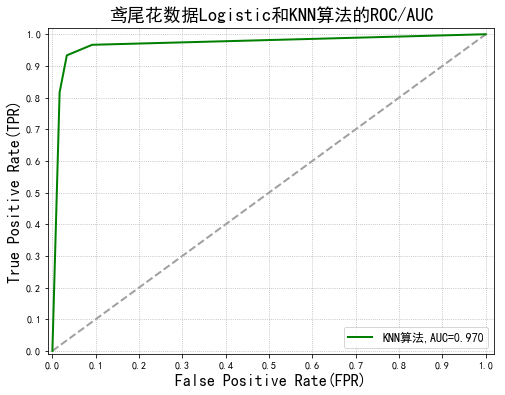

In [84]:
plt.figure(figsize=(8, 6), facecolor='w')

plt.plot((0,1),(0,1),c='#a0a0a0',lw=2,ls='--')   # 虚线
plt.plot(knn_FPR,knn_TPR,c='g',lw=2,label='KNN算法,AUC=%.3f' % knn_auc)   # ROC曲线
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)   # —— fancybox 标签框；framealpha 标签框透明度

plt.xlim(-0.01, 1.02)
plt.ylim(-0.01, 1.02)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate(FPR)', fontsize=16)
plt.ylabel('True Positive Rate(TPR)', fontsize=16)
plt.grid(b=True, ls=':')
plt.title('鸢尾花数据Logistic和KNN算法的ROC/AUC', fontsize=18)

plt.show()

##### 5、绘制预测结果图

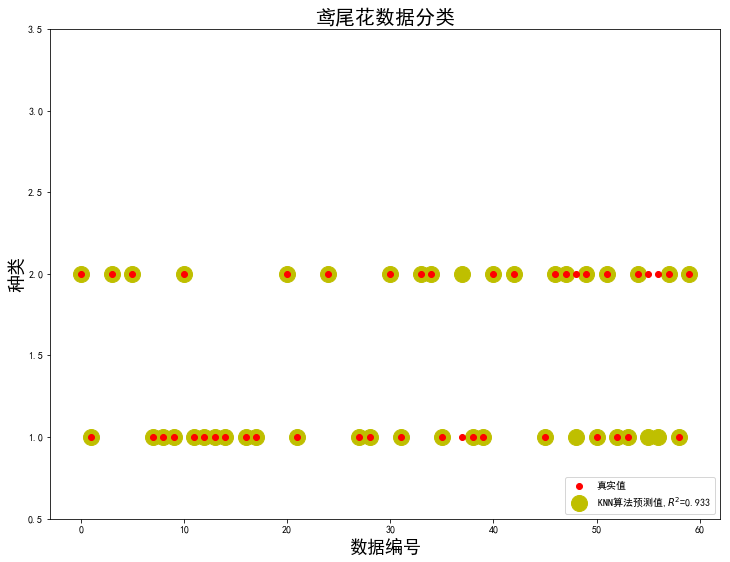

In [85]:
x_test_len = range(len(X_test))   # X轴转换
plt.figure(figsize=(12, 9), facecolor='w')

plt.plot(x_test_len, Y_test, 'ro',markersize = 6, zorder=3, label='真实值')
plt.plot(x_test_len, y_predict, 'yo', markersize = 16, zorder=1, label='KNN算法预测值,$R^2$=%.3f' % knn.score(X_test, Y_test))
plt.legend(loc = 'lower right')

plt.ylim(0.5,3.5)
plt.xlabel('数据编号', fontsize=18)
plt.ylabel('种类', fontsize=18)
plt.title('鸢尾花数据分类', fontsize=20)
plt.show()


### 数据处理：pd.Categorical().codes的实际意义

In [16]:
def parseRecord(record):   # 将cla中的值转为数字
    result=[]
    r = zip(names,record)   # ——zip() 用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
    for name,v in r:
        if name == 'cla':
            if v == 'Iris-setosa':
                result.append(1)
            elif v == 'Iris-versicolor':
                result.append(2)
            elif v == 'Iris-virginica':
                result.append(3)
            else:
                result.append(np.nan)  # 转为 NaN 一会可以删除无效样本
        else:
            result.append(float(v))
#     result = pd.Series(data = result,index = names)   # 将数组转Series
    return result   # 返回Series

In [17]:
datas = df.apply(lambda r: parseRecord(r), axis=1)  # 传df DataFrame表，按行传。每一个record为一个Series型数据
                                                    # 返回Series时组成DataFrame；返回数组时组成Series

0    [5.1, 3.5, 1.4, 0.2, 1]
1    [4.9, 3.0, 1.4, 0.2, 1]
2    [4.7, 3.2, 1.3, 0.2, 1]
3    [4.6, 3.1, 1.5, 0.2, 1]
4    [5.0, 3.6, 1.4, 0.2, 1]
dtype: object